
# Bayesian Inference for the Mining Disaster Data Set

<img src="imgs/mining.png">

An **exponential** is usually a good choice for a parameter that can have any positive value $z$

$$
Z = {\rm Exp}(\lambda) = P(z|\lambda) = \lambda e^{-\lambda}
$$

The expectation value is:

$$
E[Z | \lambda ] = 1/\lambda
$$

The **Poission** Distribution is usually a good choice for an outcome that can have any positive integer value $k$:

$$
Z = {\rm Poi}(\lambda) = P(k|\lambda) = \frac{\lambda^k e^{-k}}{k!}
$$

The expectation value is:

$$
E[Z | \lambda] = \lambda
$$

cf. https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%matplotlib inline
import scipy.stats as stats

a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, ["r","b"]):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

In [ ]:
import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1, 4]
colours = ["r","b"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values");


<img src="imgs/mining1.png">

In [ ]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk")

In [ ]:
# Disasters/year from 1850-1960
disasters = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5,
                      4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1,
                      3, 2, 2, 1, 1, 1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0,
                      3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0,
                      1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1,
                      4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
N = len(disasters)
t = np.arange(1850, 1850 + N)
# Generate random test data for comparison
#disasters = np.random.poisson(size=N, lam=2.)
plt.plot(t, disasters)

A model for annual coal mining disaster rates with a changepoint $\tau$:

$$D_t \sim \text{Poisson}\left(\begin{cases}
\mu_1 & t \leq s \\
\mu_2 & t > s
\end{cases}
\right)$$

$mu_1$ is "e" (early rate) and $mu_2$ is "l" (late rate) from above

In [ ]:
with pm.Model() as model:
    # Specify priors for s, mu_1, mu_2
    s = pm.DiscreteUniform('s', lower=t.min(), upper=t.max())
    mu = pm.Exponential('mu', lam=np.array([1., 1.]), shape=2)

    # Poisson likelihood function for observed data
    mu_1_or_2 = pm.Deterministic('mu_1_or_2', pm.math.switch(t < s, mu[0], mu[1]))
    D = pm.Poisson('D', mu_1_or_2, observed=disasters)

In [ ]:
# !pip install pydot

In [ ]:
#!brew install graphviz

Let's look at the DAG of the computation we just set up...

In [ ]:
from theano.printing import pydotprint
pydotprint(model.logpt)

In [ ]:
from IPython.display import Image
Image(filename='/Users/jbloom/.theano/compiledir_macOS-12.1-x86_64-i386-64bit-i386-3.9.9-64/theano.pydotprint.cpu.png') 

In [ ]:
with model:
    step = pm.NUTS()  # s cannot be sampled by NUTS so pymc will default to Metropolis
    trace = pm.sample(20000, step=[step], cores=2, return_inferencedata=False)
    
burned_in = trace[5000:]
thinned = burned_in[::10]

## Analyzing the posterior
We can get an idea of the behavior of our Markov chain by viewing the trace of one of the variables:

In [ ]:
_ = plt.plot(thinned['s'])

In [ ]:
#with model: # we can obtain summary statistics from the MCMC easily
pm.stats.summary(thinned,  var_names=['mu', "s"]) #summary statistics

`pymc3` also has its own built-in plotting functionality which helps quickly visualize the distribution of the variables of interest:

In [ ]:
pm.plots.traceplot?

In [ ]:
# Variable trace summary plots
import arviz

with model:
    arviz.plot_trace(thinned, var_names=['mu'], figsize=(12, 4));
    plt.legend(['mu_1', 'mu_2'])

    arviz.plot_trace(thinned, var_names=['s']);
    plt.legend(['s'])

In [ ]:
# Detailed posterior distribution plots
arviz.plot_posterior(thinned['mu'][:, 0],  figsize=(6,6));
arviz.plot_posterior(thinned['mu'][:, 1],  figsize=(6,6));

Autocorrelation plots give a rough idea of how close to i.i.d the samples from our posterior distribution are:

In [ ]:
# Full chain (no burn-in or thinning)
with model:
    arviz.plot_autocorr(trace, var_names=['s', 'mu']);

In [ ]:
with model:
    # Chain with 5000 burn-in iterations
    pm.plots.plot_autocorr(burned_in, var_names=['s', 'mu']);

In [ ]:
with model:
    # Chain with 5000 burn-in iterations, thinned by 10x
    pm.plots.plot_autocorr(thinned, var_names=['s', 'mu']);

We can also make inferences about the values of other functions/transformations of the parameters:

In [ ]:
# Posterior distribution of change in mean (mu_2 - mu_1)
change = thinned['mu'][:, 1] - thinned['mu'][:, 0]
ci = np.floor(0.975 * len(change))
plt.hist(change);
plt.title('Change in the rate: {:1.3f} (± {:1.3f})'.format(
          np.mean(change), np.abs(np.percentile(change, 2.5) - np.percentile(change, 97.5)) / 2));

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(thinned[:]["mu"][:,1], thinned[:]["mu"][:,0],alpha=0.2)

In [ ]:
# and we can also plot realizations of the model from the posterior!
plt.figure(figsize=(12, 10))
realizations = pm.sample_posterior_predictive(thinned, model=model, samples=3)
for D_i in realizations['D']:
    plt.plot(t, D_i, '-o')

In [ ]:
# now we can plot realizations of the model from the posterior!
dates = np.arange(1850,1961)
plt.figure(figsize=(12, 10))

plt.plot(t, disasters,'o-')
plt.xlim([1850,1960])
plt.xlabel('Year',fontsize=20)
plt.ylabel('# of Disasters',fontsize=20)

# plot first 250 MCMC samples
for i in np.arange(250):
    ri = thinned[i]["mu_1_or_2"]
    plt.plot(dates,ri,'-r',alpha=0.3)

## Convergence Diagnostics

Determining whether an MCMC has converged can be difficult, especially in high-dimensional parameter spaces 

A number of diagnostics (both formal and informal) exist, and many of these are available in arviz `arviz.stats.diagnostics` (https://python.arviz.org/en/latest/api/diagnostics.html), e.g.:
- ess: Calculate estimate of the effective sample size (ess).
- rhat: Compute estimate of rank normalized splitR-hat for a set of traces.

In [ ]:
with model:
    print(arviz.rhat(thinned, method="z_scale", var_names=["mu"]))

- **First check** - start multiple chains from different starting values and see that they converge to the same place
- **More formal methods** - Raftery-Lewis, autocorrelation, etc. 
- **Goodness of fit** Posterior Predictive Checks which simulate data from your fitted model and compare to the observed data (checks convergence AND the suitability of the chosen model)

## Other MCMC Code on the Market

- WinBUGS, OpenBUGS - Bayesian inference Using Gibbs Sampling JAGS - Just Another Gibbs Sampler (C++)

- in R -
mcmc, rbugs, BRugs, MCMCpack, adaptMCMC, rjags, etc. See rpy2 (http://rpy.sourceforge.net/rpy2.html)

- in Python -
   - bayesian-inference (http://code.google.com/p/bayesian-inference/) 
   - emcee (http://danfm.ca/emcee/)

## What about Bayesian Approaches to Machine Learning?

- Many of the “Bayesian” ML approaches (e.g., Naive Bayes, Bayes Nets) are usually applied in a Frequentist way
    - “prior” probabilities are estimated with MLE instead of assigning probability distributions (e.g., Dirichlet)

- Bayesian NNs
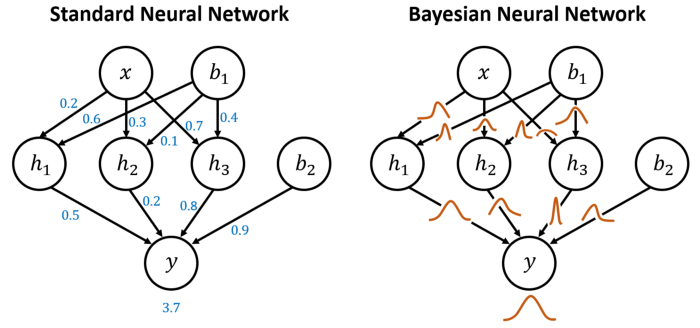

[Source](https://towardsdatascience.com/why-you-should-use-bayesian-neural-network-aaf76732c150)


- There are lots of great non-parametric Bayes approaches (many of which are being developed here at Berkeley!)
   - Gaussian processes (priors over smooth functions)
   - Dirichlet processes (priors over allocation of objects to classes)